In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
from collections import Counter


def parseDataset(path):
    df = pd.read_table(path, delimiter='\t', names=['source','target'])
    return df

In [2]:
#Graph creation
dataset_path= "dataset.txt"
data = parseDataset(dataset_path)
G= nx.from_pandas_edgelist(data,"source","target")

In [3]:
#generic analysis
print(G)


Graph with 58228 nodes and 214078 edges


In [4]:
#distances analysis (ci metterà una vita, la giant component richiederà ore)
'''
distances_sum = 0
all_p = []
for C in (G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)):
    p = dict(nx.shortest_path_length(C)) #questo conterrà tutte le distanze, per poter guardare max, min e media
    all_p.append(p)
    distance = nx.average_shortest_path_length(C)
    print(distance)
    distances_sum += distance

print("Average distance: ", distances_sum/len(nx.connected_components(G)))
print("Max distance: ", max(p.values() for p in all_p))
print("Min distance: ", min(p.values() for p in all_p))
with open('measures.txt', 'w') as f:
    print(f"distance sum: {distances_sum}\n", file=f)
    print(all_p, file=f)
    '''

'\ndistances_sum = 0\nall_p = []\nfor C in (G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)):\n    p = dict(nx.shortest_path_length(C)) #questo conterrà tutte le distanze, per poter guardare max, min e media\n    all_p.append(p)\n    distance = nx.average_shortest_path_length(C)\n    print(distance)\n    distances_sum += distance\n\nprint("Average distance: ", distances_sum/len(nx.connected_components(G)))\nprint("Max distance: ", max(p.values() for p in all_p))\nprint("Min distance: ", min(p.values() for p in all_p))\nwith open(\'myfile.txt\', \'w\') as f:\n    print(f"distance sum: {distances_sum}\n", file=f)\n    print(all_p, file=f)\n    '

In [5]:
#clustering coefficient
print("Clustering coefficient: "+str(nx.average_clustering(G)))


Clustering coefficient: 0.17232592744613273


Il grafo è connesso? False
Componenti connesse: 547
largest connected component size: 56739
[56739, 49, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

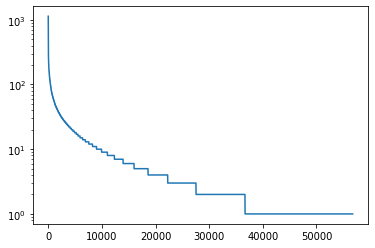

In [6]:
#largest connected component
print("Il grafo è connesso? "+str(nx.is_connected(G)))
print("Componenti connesse: "+ str(nx.number_connected_components(G)))
core_nodes = max(nx.connected_components(G), key=len)
print(f"largest connected component size: {len(core_nodes)}")
core = G.subgraph(core_nodes)
print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

#analizzo i degree all'interno della sola largest connected components per scoprire se la sua dimensione è dovuta a molti nodi che si incontrano oppure a supernodi Hub
largest_component = G.subgraph(core_nodes).copy()
core_degree_sequence = sorted([d for n, d in largest_component.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(core_degree_sequence)
#nx.draw(core, with_labels=True)

average degree: 7.353094731057223
21157
degree sequence: [1134, 1055, 854, 838, 833, 779, 732, 569, 550, 475, 467, 453, 448, 404, 386, 379, 354, 343, 337, 334, 333, 332, 327, 326, 325, 321, 311, 310, 306, 301, 299, 296, 292, 289, 282, 274, 272, 271, 270, 270, 270, 267, 267, 266, 264, 259, 257, 256, 254, 253, 253, 248, 242, 241, 230, 230, 228, 228, 228, 227, 226, 225, 225, 221, 218, 218, 215, 214, 214, 213, 213, 212, 211, 210, 210, 210, 210, 209, 207, 206, 206, 205, 204, 203, 202, 202, 202, 201, 201, 198, 198, 194, 193, 192, 192, 191, 190, 190, 190, 190, 190, 189, 188, 188, 187, 186, 185, 184, 184, 183, 181, 180, 179, 178, 178, 177, 176, 176, 175, 175, 175, 174, 173, 173, 173, 173, 173, 172, 172, 172, 172, 172, 172, 171, 171, 170, 170, 169, 168, 168, 168, 168, 168, 167, 167, 166, 166, 166, 165, 164, 163, 163, 163, 163, 162, 162, 162, 162, 162, 162, 161, 161, 161, 160, 160, 160, 160, 159, 158, 158, 157, 156, 155, 155, 153, 153, 153, 153, 152, 151, 151, 150, 150, 150, 149, 149, 149, 149, 

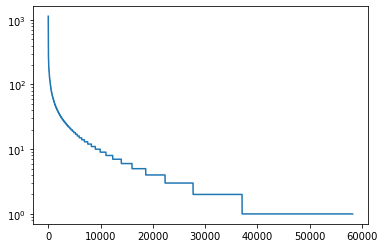

In [7]:
#degree analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(degree_sequence)

print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
#wtf? average degree 7?
print(degree_sequence.count(min(degree_sequence)))
#ah, ecco perchè.

print("degree sequence: " + str(degree_sequence))

In [8]:
#Degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

Degree correlation: 0.010815796314560602
Degree correlation: 0.009622679947904226


In [9]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))


Counter({8: 7790, 1: 7711, 3: 4913, 14: 3841, 0: 3199, 6: 2517, 10: 2327, 21: 1736, 7: 1607, 2: 1163, 13: 1135, 11: 1104, 9: 1003, 23: 946, 39: 822, 33: 795, 19: 718, 18: 691, 25: 673, 36: 665, 12: 548, 16: 543, 38: 537, 60: 518, 20: 510, 17: 504, 40: 488, 35: 479, 52: 399, 4: 394, 42: 377, 45: 359, 63: 324, 29: 319, 48: 317, 49: 303, 24: 274, 57: 257, 15: 253, 44: 249, 30: 244, 37: 241, 28: 234, 47: 226, 54: 221, 70: 208, 46: 205, 41: 203, 22: 173, 51: 142, 73: 134, 59: 90, 87: 57, 27: 52, 96: 40, 67: 33, 5: 32, 66: 25, 107: 23, 26: 22, 90: 22, 91: 20, 125: 18, 61: 16, 89: 16, 64: 15, 101: 14, 75: 13, 153: 13, 79: 12, 92: 12, 158: 12, 34: 11, 80: 11, 127: 11, 161: 11, 163: 11, 74: 10, 81: 10, 109: 10, 118: 10, 146: 10, 168: 10, 31: 9, 85: 9, 111: 9, 119: 9, 141: 9, 170: 9, 53: 8, 114: 8, 117: 8, 129: 8, 132: 8, 155: 8, 178: 8, 82: 7, 83: 7, 94: 7, 98: 7, 99: 7, 120: 7, 160: 7, 171: 7, 56: 6, 69: 6, 84: 6, 104: 6, 108: 6, 133: 6, 134: 6, 136: 6, 139: 6, 150: 6, 162: 6, 164: 6, 169: 6, 

'si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c\'è un cluster di comunità che fungono da "intermediari"\ntra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.\n'

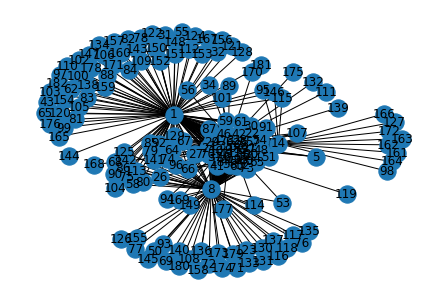

In [10]:
#plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#TODO: aggiustare la dimensione dell'immagine, se si decommenta la linea precedente il grafo delle comunità diventa un amoung us
#per ignorare quelle da due è meglio valutare solo la largest_component
induced_graph = community.induced_graph(largest_component_communities, largest_component, weight='WEIGHT')
induced_graph.remove_edges_from(nx.selfloop_edges(induced_graph))

nx.draw(induced_graph, with_labels=True, pos=nx.spring_layout(induced_graph))
'''si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c'è un cluster di comunità che fungono da "intermediari"
tra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.
'''

In [11]:
#centrality analysis
#troppo grande per nx.closeness_centrality(G)
print("betweenness centrality: "+str(sum(nx.betweenness_centrality(G,k=100).values())/58228))
#sarebbe interessante valutare la betwenness di alcuni nodi particolari

betweenness centrality: 6.449745393783504e-05


average degree: 7.353094731057223
21157
degree sequence: [1134, 1055, 854, 838, 833, 779, 732, 569, 550, 475, 467, 453, 448, 404, 386, 379, 354, 343, 337, 334, 333, 332, 327, 326, 325, 321, 311, 310, 306, 301, 299, 296, 292, 289, 282, 274, 272, 271, 270, 270, 270, 267, 267, 266, 264, 259, 257, 256, 254, 253, 253, 248, 242, 241, 230, 230, 228, 228, 228, 227, 226, 225, 225, 221, 218, 218, 215, 214, 214, 213, 213, 212, 211, 210, 210, 210, 210, 209, 207, 206, 206, 205, 204, 203, 202, 202, 202, 201, 201, 198, 198, 194, 193, 192, 192, 191, 190, 190, 190, 190, 190, 189, 188, 188, 187, 186, 185, 184, 184, 183, 181, 180, 179, 178, 178, 177, 176, 176, 175, 175, 175, 174, 173, 173, 173, 173, 173, 172, 172, 172, 172, 172, 172, 171, 171, 170, 170, 169, 168, 168, 168, 168, 168, 167, 167, 166, 166, 166, 165, 164, 163, 163, 163, 163, 162, 162, 162, 162, 162, 162, 161, 161, 161, 160, 160, 160, 160, 159, 158, 158, 157, 156, 155, 155, 153, 153, 153, 153, 152, 151, 151, 150, 150, 150, 149, 149, 149, 149, 

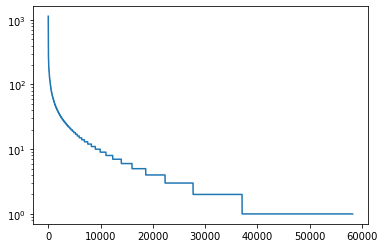

In [12]:
#degree analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(degree_sequence)

print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
#wtf? average degree 7?
print(degree_sequence.count(min(degree_sequence)))
#ah, ecco perchè.

print("degree sequence: " + str(degree_sequence))

In [13]:
#Degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

Degree correlation: 0.010815796314560602
Degree correlation: 0.009622679947904226


Counter({5: 8434, 1: 7368, 2: 4771, 0: 4101, 16: 3717, 11: 2179, 39: 1870, 13: 1724, 6: 1576, 23: 1468, 8: 1319, 9: 1026, 25: 994, 7: 962, 10: 912, 36: 893, 24: 697, 21: 694, 31: 642, 12: 616, 41: 604, 26: 589, 14: 573, 50: 494, 46: 435, 28: 398, 45: 384, 52: 374, 22: 370, 54: 350, 53: 344, 47: 342, 20: 336, 40: 314, 49: 309, 30: 303, 43: 294, 32: 274, 61: 273, 57: 271, 18: 235, 19: 221, 35: 213, 15: 207, 38: 202, 42: 197, 27: 174, 60: 166, 3: 159, 17: 145, 51: 134, 55: 101, 59: 82, 91: 40, 4: 32, 29: 22, 85: 22, 86: 21, 37: 20, 66: 20, 63: 19, 84: 16, 95: 14, 69: 13, 73: 13, 83: 13, 102: 13, 118: 13, 89: 12, 148: 12, 76: 11, 78: 11, 121: 11, 149: 11, 151: 11, 72: 10, 79: 10, 96: 10, 100: 10, 139: 10, 156: 10, 33: 9, 101: 9, 108: 9, 134: 9, 147: 9, 158: 9, 107: 8, 122: 8, 126: 8, 157: 8, 80: 7, 81: 7, 93: 7, 97: 7, 112: 7, 159: 7, 56: 6, 64: 6, 82: 6, 92: 6, 99: 6, 109: 6, 127: 6, 128: 6, 130: 6, 132: 6, 141: 6, 150: 6, 152: 6, 161: 6, 169: 6, 34: 5, 58: 5, 62: 5, 70: 5, 90: 5, 94: 5, 

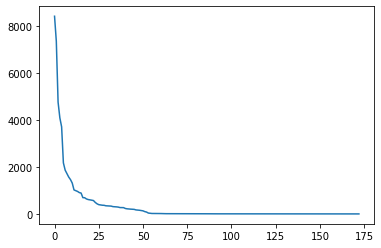

In [14]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))
plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#per ignorare quelle da due è meglio valutare solo la largest_component

In [15]:
#degree correlation
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))


Degree correlation: 0.010815796314560602
Degree correlation: 0.009622679947904226
